# 数据观察及预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
taitannike_data=pd.read_csv(r'/Users/jacquelin/Documents/python/MachineLearning-imooc-master/机器学习项目实战/泰坦尼克船员获救/titanic_train.csv')

In [44]:
data=taitannike_data.copy()
data.head()
#data.describe()
import warnings
warnings.filterwarnings('ignore')

In [45]:
#年龄缺失值处理
data['Age']=data['Age'].fillna(data['Age'].median())
#性别字段转化为计算字段
data['Sex'].unique()    #测试是否需要为其他性别取值
data['Sex']=data['Sex'].replace('male',0)
data['Sex']=data['Sex'].replace('female',1)
#登船地点
data['Embarked'].unique()
data['Embarked']=data['Embarked'].fillna('S')
data['Embarked']=data['Embarked'].replace('S',0)
data['Embarked']=data['Embarked'].replace('C',1)
data['Embarked']=data['Embarked'].replace('Q',2)
data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,0.361392
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.635673
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


# 训练模型

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

X=data[features]
y=data['Survived']

kf=KFold(n_splits=3, shuffle=False,random_state=666)


predictions=[]
for train,test in kf.split(data):
    lin_reg=LinearRegression()
    X_train=(data[features].iloc[train,:])
    y_train=data['Survived'].iloc[train]
    lin_reg.fit(X_train,y_train)
    prediction=lin_reg.predict(data[features].iloc[test,:])
    predictions.append(prediction)
#predictions是三个验证集的预测值，需要合并
predictions=np.concatenate(predictions,axis=0)
#predictions是一些概率值，需要对其分类
predictions[predictions>.5]=1
predictions[predictions<=.5]=0
#看精确度
accuracy=sum(predictions==data['Survived'])/len(predictions)
accuracy

0.7833894500561167

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(random_state=666)
scores=cross_val_score(log_reg,data[features],data['Survived'],cv=3)
scores.mean()

0.7878787878787877

### 随机森林改进模型

In [58]:
from sklearn.ensemble import RandomForestClassifier
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

rf_clf=RandomForestClassifier(random_state=666,n_estimators=100,  #有多少棵树
                             min_samples_split=2,min_samples_leaf=1)   #限制有多高

scores=cross_val_score(rf_clf,data[features],data['Survived'],cv=kf)
scores.mean()
#好一点点，，，哭泣


0.7946127946127947

In [61]:
#调参
rf_clf2=RandomForestClassifier(random_state=666,n_estimators=500,  #有多少棵树
                             min_samples_split=4,min_samples_leaf=3)   #限制有多高

scores1=cross_val_score(rf_clf2,data[features],data['Survived'],cv=kf)
scores1.mean()

0.8170594837261503

In [ ]:
'''random_state
        作为每次产生随机数的种子
        作为随机种子对于调参过程是很重要的，如果每次都用不同的随机种子。即使参数值没变，每次出来的结果也会不同，不利于比较不同模型的结果
        任一个随机样本都有可能导致过度你和，可以用不同的随机样本建模来减少过拟合到的可能
n_estimators
        定义了需要用到的决策树的数量

min_samples_split
        定义了书中一个节点所需要用来分裂的最少样本数
        可以避免过拟合，如果用于分类的样本数太小，模型可能只试用于用来训练样本的分类，而用较多的样本数则可以避免这个问题
        如果设定的值过大，就可能出现欠拟合现象，所以可以用cv值(离散数量)考量调节效果
min_samples_leaf
        定义了树中终点节点所需要用来分裂的最少样本数
        同样，可以防止过度拟合
        不均等分类问题中，一般这个参数需要设定为较小的值。因为大部分少数类别含有的样本都比较小
min_weight_fraction_leaf
        和上面的min_simples_leaf 很像，，不同的是这个参数需要被设定为较小的值，因为大部分少数类别含有的样本都比较小
        #2和#3只需要定义一个就行了
max_depth
        定义和树的最大深度
        也可以控制过拟合，树越深，越容易过拟合
        也可以用CV值检验
max_leaf_nodes
        定义了决策树里最多能有多少个终点节点
        这个属性可能在上面的max_depth里就被定义了，深度为n的二叉树就有最多2的n次方的终点节点
        如果定义max_leaf_nodes GBM就会忽略前面的  max_depth
max_features
        决定了用于分类的特征树，是认为随机定义的
        根据经验一般选择总特征数的平方根就可以工作的很好，最多可以尝试总特征数的30%-40%'''


### 调参效果不明显，处理原数据

In [73]:
#家庭背景
import re
data['Familysize']=data['SibSp']+data['Parch']   #家庭背景，家里有多少人
data['Namelength']=data['Name'].apply(lambda x: len(x))     #姓名长度

def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ''
titles=data['Name'].apply(get_title)
pd.value_counts(titles)   #查看提取的社会称呼
title_map={"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for i,j in title_map.items():
    titles[titles==i]=j
pd.value_counts(titles)    #再次提取修改后的社会称呼
data['Title']=titles

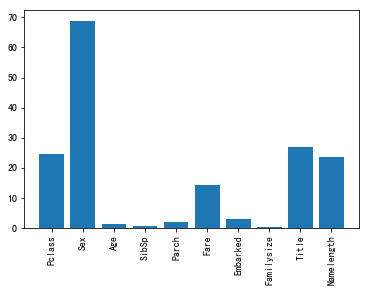

In [85]:
#对特征生成后的结果，考察特征重要性，适当舍弃特征，减少噪音
#原理：将一个特征的值换成噪音后考察scores，无变化则说明此特征重要性低
from sklearn.feature_selection import SelectKBest,f_classif
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Familysize", "Title", "Namelength"]
selector=SelectKBest(f_classif,k=5)
selector.fit(data[features],data['Survived'])
scores=-np.log10(selector.pvalues_)
plt.bar(range(len(features)),scores)
plt.xticks(range(len(features)),features,rotation='vertical')
plt.show()

In [90]:
features_re = ["Pclass", "Sex", "Fare", "Title","Namelength",'Familysize','Age','Embarked']
#rf_clf2.fit(data[features_re],data['Survived'])
#rf_clf2.score()
scores1=cross_val_score(rf_clf2,data[features_re],data['Survived'],cv=kf)
scores1.mean()

0.8305274971941637

### 使用梯度提升决策树与逻辑回归集成

In [103]:


from sklearn.ensemble import GradientBoostingClassifier

algorithms=[
    [GradientBoostingClassifier(random_state=666,n_estimators=500,max_depth=3),features_re],
    [LogisticRegression(random_state=666),features_re]
]

kf=KFold(n_splits=3, shuffle=False,random_state=666)


predictions=[]
for train,test in kf.split(data):
    y_train=data['Survived'].iloc[train]
    full_test_pridicts=[]
    for alg,features in algorithms:
        alg.fit(data[features].iloc[train,:],y_train)
        test_prediction=alg.predict_proba(data[features].iloc[test,:].astype(float))[:,1]
        full_test_pridicts.append(test_prediction)
    mean_predict=(full_test_pridicts[0]+full_test_pridicts[1])/2
    mean_predict[mean_predict>.5]=1
    mean_predict[mean_predict<=.5]=0
    predictions.append(mean_predict)
    
#predictions是三个验证集的预测值，需要合并
predictions=np.concatenate(predictions,axis=0)

#看精确度
accuracy=sum(predictions==data['Survived'])/len(predictions)
accuracy



0.8226711560044894

### 预测数据

In [111]:
data_test=pd.read_csv(r'/Users/jacquelin/Documents/python/MachineLearning-imooc-master/机器学习项目实战/泰坦尼克船员获救/test.csv')
#年龄缺失值处理
data_test['Age']=data_test['Age'].fillna(data_test['Age'].median())
#性别字段转化为计算字段
data_test['Sex'].unique()    #测试是否需要为其他性别取值
data_test['Sex']=data_test['Sex'].replace('male',0)
data_test['Sex']=data_test['Sex'].replace('female',1)
#登船地点
data_test['Embarked'].unique()
data_test['Embarked']=data_test['Embarked'].fillna('S')
data_test['Embarked']=data_test['Embarked'].replace('S',0)
data_test['Embarked']=data_test['Embarked'].replace('C',1)
data_test['Embarked']=data_test['Embarked'].replace('Q',2)

data_test['Fare']=data_test['Fare'].fillna(data_test['Fare'].median())
data_test['Namelength']=data_test['Name'].apply(lambda x: len(x))

titles=data_test['Name'].apply(get_title)
pd.value_counts(titles)   #查看提取的社会称呼
title_map={"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2,"Dona": 10}
for i,j in title_map.items():
    titles[titles==i]=j
pd.value_counts(titles)    #再次提取修改后的社会称呼
data_test['Title']=titles
data_test["Familysize"] = data_test["SibSp"] + data_test["Parch"]

print(pd.value_counts(data_test["Title"]))


1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [113]:
#预测
features_re = ["Pclass", "Sex", "Fare", "Title","Namelength",'Familysize','Age','Embarked']
full_predicts=[]
for alg,features in algorithms:
    alg.fit(data[features_re],data['Survived'])
    predicts=alg.predict_proba(data_test[features_re].astype('float'))[:,1]
    full_predicts.append(predicts)
predicts=(full_test_pridicts[0]*3+full_test_pridicts[1])/4
predicts

array([0.04627479, 0.11519204, 0.84358935, 0.03736619, 0.04069662,
       0.97161622, 0.95751399, 0.03362191, 0.14033745, 0.26531132,
       0.699738  , 0.11012631, 0.04836598, 0.64985838, 0.97505964,
       0.95471337, 0.64828395, 0.02514425, 0.8655776 , 0.07157067,
       0.11390403, 0.84945962, 0.01963337, 0.75608873, 0.9389651 ,
       0.14382586, 0.0253306 , 0.57991752, 0.02666995, 0.06730642,
       0.07207184, 0.09493079, 0.14008445, 0.97278174, 0.10600405,
       0.19539298, 0.03959109, 0.01357474, 0.92299086, 0.12645322,
       0.08208274, 0.91373819, 0.22012073, 0.0482174 , 0.09054296,
       0.02976566, 0.07180673, 0.99530296, 0.13071874, 0.05090946,
       0.81731869, 0.20219279, 0.05059163, 0.93805493, 0.02153135,
       0.32734777, 0.03277055, 0.92403935, 0.0491872 , 0.90211661,
       0.95057539, 0.06041249, 0.04007335, 0.89008228, 0.16061467,
       0.21902243, 0.16991343, 0.02466184, 0.07081706, 0.12255545,
       0.06130789, 0.13334223, 0.21764597, 0.04973594, 0.08630